## 1.1 Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, log_loss
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksejfilippov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksejfilippov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
data_train_gen = pd.read_csv("/Users/aleksejfilippov/Desktop/techotrack/quora/csvs/train.csv")
data_test = pd.read_csv("/Users/aleksejfilippov/Desktop/techotrack/quora/csvs/test.csv")
print("Train datasets shape:", data_train_gen.shape)
print("Test datasets shape:", data_test.shape)

Train datasets shape: (1306122, 3)
Test datasets shape: (56370, 2)


In [29]:
data_train_gen.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


##  1.2 Посмотрим на число вхождений

In [30]:
NUMBER_OF_1_LABELS = data_train_gen.target.value_counts()[1]
NUMBER_OF_1_LABELS

80810

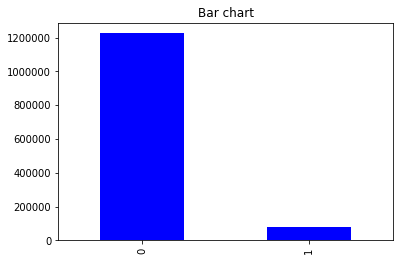

In [31]:
count_Class=pd.value_counts(data_train_gen.target, sort= True)
count_Class.plot(kind= 'bar', color= ["blue"])
plt.title('Bar chart')
plt.show()

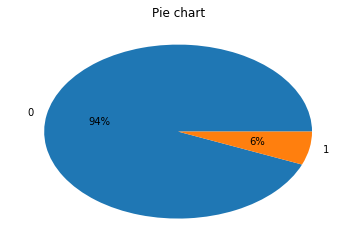

In [32]:
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## 1.3 Сбалансируем выборку

In [33]:
num = 653826
bad_df = data_train_gen[data_train_gen.target == 1]
good_df = data_train_gen[data_train_gen.target == 0][:num]
data_train = pd.concat([bad_df, good_df])

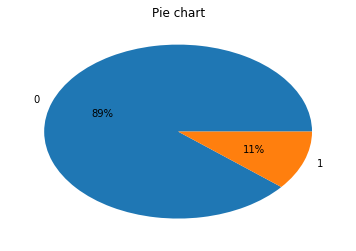

In [34]:
count_Class=pd.value_counts(data_train.target, sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart')
plt.ylabel('')
plt.show()

## 1.4 Перемешаем наш сбалансированый data_train_gen

In [35]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
data_train = data_train[:10]

## 2.1 Рассмотрим самые часто встречающиеся слова в вопросах

In [36]:
count1 = Counter(" ".join(data_train[data_train['target']==0].question_text).split()).most_common(50)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words_in_excellent ", 1 : "count_1"})
df1.T

#### Заметим, что самыми популярными топ-50 словами явялются предлоги, местоимения, междометия и прочее, потому уберем такие слова из обучающей выборки , так как они не показывают определенную принадлежность к классу.

In [37]:
quiestion_words = ['what','when','why','which','who','how', 'whose', 'whome', 'people', 'i', 
                  'n\'t','\'s','like','get','would','would']
stop_signs = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
stop_words = stopwords.words('english')
stop_words = stop_words.extend(quiestion_words)
for w in quiestion_words:
    stop_words.append(w)
for w in stop_signs:
    stop_words.append(w)

In [38]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

## 2.2 Уберем из предложений самые часто встречающиеся слова 

#### Также приведем все слова к lower case и выкинем некоторые знаки препинания.

In [39]:
cleaned_questions_train = []
 
for sentence in data_train['question_text']:
    new_sentence = [wordnet_lemmatizer.lemmatize(w).lower() for w in word_tokenize(sentence)]
    new_sentence = [w for w in new_sentence if w not in stop_words]
    new_sentence = [w for w in new_sentence if len(w)>3]
         
    clean = ' '.join(new_sentence)    
   
    cleaned_questions_train.append(clean)

cleaned_questions_test = []
for sentence in data_test['question_text']:
    new_sentence = [wordnet_lemmatizer.lemmatize(w).lower() for w in word_tokenize(sentence)]
    new_sentence = [w for w in new_sentence if w not in stop_words]
    new_sentence = [w for w in new_sentence if len(w)>3]
         
    clean = ' '.join(new_sentence)    
   
    cleaned_questions_test.append(clean)

In [40]:
data_train.insert(loc=0, column="debugged_questions", value=cleaned_questions_train)
data_test.insert(loc=0, column="debugged_questions", value=cleaned_questions_test)
data_test.head()

,debugged_questions,qid,question_text
0,voice range a2-c5 chest voice included sample ...,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,much tutor earn bangalore,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,best made pocket knife 200-300,000227734433360e1aae,What are the best made pocket knives under $20...
3,hypothetical scenario impossible happen link s...,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,dresscode techmahindra fresher,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


#### Выберем список уникальных слов из train и test, чтобы позже использовать его как словарь для TFidf.

In [41]:
words = []

for sen in pd.concat([data_train.debugged_questions, data_test.debugged_questions]):
    for word in sen.split():
        if word not in words:
            words.append(word)


In [42]:
text = [word_tokenize(t) for t in pd.concat([data_train.debugged_questions, data_test.debugged_questions])]

In [43]:
from gensim import corpora
import gensim

In [ ]:
dictionary = corpora.Dictionary(text)
corpus = [dictionary.doc2bow(text) for text in text]
lda = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, 
                                              num_topics=10, chunksize=10, passes=20
                                             )


In [18]:
y = data_train.target

In [19]:
vectorizer = TfidfVectorizer("english", vocabulary = words)
X = vectorizer.fit_transform(data_train['debugged_questions'])
X_val = vectorizer.fit_transform(data_test['debugged_questions'])

## 3.1 Строим решающие деревья по сетке параметров. 

In [418]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [419]:
grid = OrderedDict((
        ('max_depth',np.arange(2,20,4)),
        ('min_samples_leaf',np.exp(np.linspace(3,8,5)).astype(int))))

result = {'params':[],'roc_auc_train':[],'roc_auc_valid':[], 'f1_train':[], 'f1_valid':[]}

for param_values in itertools.product(*grid.values()):
    param = dict(zip(grid.keys(),param_values))
    clf = DecisionTreeClassifier(**param)

    clf.fit(X_train,y_train)

    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_test)

    roc_auc_train = roc_auc_score(y_train,train_pred)
    roc_auc_valid = roc_auc_score(y_test,valid_pred)
    f1_train = f1_score(y_train,train_pred)
    f1_test = f1_score(y_test,valid_pred)
    result['params'].append(param)
    result['roc_auc_train'].append(roc_auc_train)
    result['roc_auc_valid'].append(roc_auc_valid)
    result['f1_train'].append(f1_train)
    result['f1_valid'].append(f1_test)

# Выводим результаты    
(pd.DataFrame(result)   
   .style
   .background_gradient('Wistia')
)


/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,params,roc_auc_train,roc_auc_valid,f1_train,f1_valid
0,"{'max_depth': 2, 'min_samples_leaf': 20}",0.561098,0.565172,0.218845,0.229885
1,"{'max_depth': 2, 'min_samples_leaf': 70}",0.567017,0.575727,0.235877,0.257778
2,"{'max_depth': 2, 'min_samples_leaf': 244}",0.5,0.5,0,0
3,"{'max_depth': 2, 'min_samples_leaf': 854}",0.5,0.5,0,0
4,"{'max_depth': 2, 'min_samples_leaf': 2980}",0.5,0.5,0,0
5,"{'max_depth': 6, 'min_samples_leaf': 20}",0.610818,0.610415,0.352283,0.344681
6,"{'max_depth': 6, 'min_samples_leaf': 70}",0.567017,0.575727,0.235877,0.257778
7,"{'max_depth': 6, 'min_samples_leaf': 244}",0.5,0.5,0,0
8,"{'max_depth': 6, 'min_samples_leaf': 854}",0.5,0.5,0,0
9,"{'max_depth': 6, 'min_samples_leaf': 2980}",0.5,0.5,0,0


#### видим, что на validation выборке лучший результат по метрике F1 при max_depth = 18 и min_samples_leaf = 20

## 3.2 Возможно найдем лучшие параметры, используя Grid Search

In [19]:
first_tree = DecisionTreeClassifier()
tree_params_grid = {'max_depth' : np.arange(2,18,4),'min_samples_leaf': [20,70,244,854]}
tree_grid=GridSearchCV(first_tree,tree_params_grid,scoring='f1'
                        ,cv=5,n_jobs = -1)

tree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 2,  6, 10, 14]), 'min_samples_leaf': [20, 70, 244, 854]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [20]:
tree_grid.best_score_, tree_grid.best_params_

(0.7559379504883844, {'max_depth': 6, 'min_samples_leaf': 20})

#### Параметры, подобранные руками показывают результат(0.76) лучше, чем Grid search(0.75). Тогда окончательную модель строим на параметрах max_depth = 18 и min_samples_leaf = 20

In [21]:
f_tree = DecisionTreeClassifier(max_depth = 18, min_samples_leaf = 20)
f_tree.fit(X_train,y_train)
prediction = f_tree.predict(X_test)
f1 = f1_score(y_test, prediction)
f1

0.7364209170767603

## Анализ ошибок модели

#### Нарисуем кривую ROC

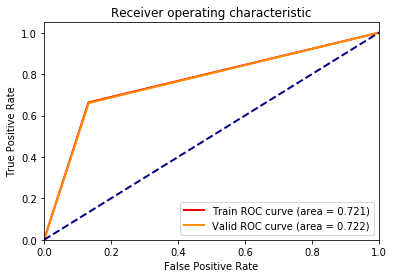

In [22]:
from sklearn.metrics import roc_curve, auc

train_predict = f_tree.predict(X_train)
valid_predict = f_tree.predict(X_test)

plt.figure()
lw = 2
plt.plot(*roc_curve(y_train,train_predict)[:-1], color='red',
         lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc_train)
plt.plot(*roc_curve(y_test,valid_predict)[:-1], color='darkorange',
         lw=lw, label='Valid ROC curve (area = %0.3f)' % roc_auc_valid)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Делаем submission

In [657]:
sub_df = pd.DataFrame({'qid':data_test.qid.values})
sub_df['prediction'] = f_tree.predict(X_val)
sub_df.to_csv('submission.csv', index=False)